In [1]:
import folium # O pacote folium é utilizado para renderizar os dados em um mapa no Jupyter.
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; // disable scroll bar when displaying Folium map
}

<IPython.core.display.Javascript object>

# Assignment 2

Os dados para esta tarefa vêm de um subconjunto dos Centros Nacionais de Informações Ambientais (NCEI) [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) (GHCN-Diário). O GHCN-Daily é composto por registros climáticos diários de milhares de estações de superfície terrestre em todo o mundo - é um conjunto de dados maravilhosamente grande para brincar! Em particular, você será solicitado a usar dados do local de Ann Arbor Michigan (minha casa!). e isso é armazenado no arquivo: `assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`

Cada linha neste arquivo de dados corresponde a uma única observação de uma estação meteorológica e possui as seguintes variáveis:
* **id**: código de identificação da estação
* **date** : data no formato AAAA-MM-DD (por exemplo, 2012-01-24 = 24 de janeiro de 2012)
* **element** : indicador do tipo de elemento
     * TMAX : Temperatura máxima (décimos de graus C)
     * TMIN : Temperatura mínima (décimos de graus C)
* **value** : valor dos dados para o elemento (décimos de graus C)

Para esta tarefa, você deve:

1. Leia a documentação e familiarize-se com o conjunto de dados, em seguida, escreva um notebook python que plota gráficos de linha do recorde de alta e baixa temperatura por dia do ano durante o período de 2005-2014. A área entre as temperaturas máximas e mínimas recordes para cada dia deve ser sombreada.
2. Sobreponha uma dispersão dos dados de 2015 para quaisquer pontos (máximos e mínimos) para os quais o recorde de dez anos (2005-2014) foi quebrado em 2015. (Com base no gráfico, você acha que o clima extremo é ficando mais frequente em 2015?)
3. Cuidado com os dias bissextos (ou seja, 29 de fevereiro), é razoável remover esses pontos do conjunto de dados para fins desta visualização.
4. Torne o visual agradável! Aproveite os princípios do primeiro módulo deste curso ao desenvolver sua solução. Considere questões como legendas, rótulos e lixo gráfico.

Escrevi algumas etapas que acho que seriam boas de seguir, mas há outras maneiras de resolver esta tarefa, portanto, sinta-se à vontade para explorar a biblioteca de pandas! O que eu realmente quero ver é uma imagem que se pareça com este esboço que desenhei na minha mesa:

![](assets/chris_sketch.png)

In [3]:
# get the location information for this dataset
df = pd.read_csv('assets/BinSize_d400.csv')
station_locations_by_hash = df[df['hash'] == 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89']

# get longitude and lattitude to plot
lons = station_locations_by_hash['LONGITUDE'].tolist()
lats = station_locations_by_hash['LATITUDE'].tolist()

# plot on a beautiful folium map
my_map = folium.Map(location = [lats[0], lons[0]], height = 500,  zoom_start = 9)
for lat, lon in zip(lats, lons):
    folium.Marker([lat, lon]).add_to(my_map)

# render map in Jupyter
display(my_map)

## Step 1

Carregue o conjunto de dados e transforme os dados em Celsius (consulte a documentação) e extraia todas as linhas que possuem temperaturas mínimas ou máximas.

__dica: quando fiz esta etapa, eu tinha dois objetos DataFrame, cada um com aproximadamente 80.000 entradas__

In [4]:
df = pd.read_csv('assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

# Removendo ****-02-29 
df['Date'] = pd.to_datetime(df['Date'])
mask = ((df['Date'].dt.month == 2) & (df['Date'].dt.day == 29))
df = df[~mask]

df.loc[:,'Data_Value'] = df['Data_Value'] / 10
dfMax = df[df["Element"] == "TMAX"]
dfMin = df[df["Element"] == "TMIN"]

In [5]:
dfMax.shape

(83020, 4)

In [6]:
dfMin.shape

(81982, 4)

## Step 2

Para visualizar os dados, traçaríamos os dados mínimos e máximos para cada dia do ano entre os anos de 2005 e 2014 em todas as estações meteorológicas. Mas também precisamos descobrir quando a temperatura mínima ou máxima em 2015 cai abaixo do mínimo ou sobe acima do máximo da década anterior.

Se você fez o passo 1, você tem dois objetos Series com tempos mínimo e máximo para os anos de 2005 a 2015. Você pode usar Pandas `groupby` para criar objetos Series de temperatura máxima e mínima em todas as estações meteorológicas para cada dia desses anos, e você pode lidar com os registros de 29 de fevereiro (o ano bissexto) descartando-os.

__dica: quando terminei esta etapa, eu tinha dois objetos DataFrame, cada um com exatamente 4015 observações neles__

In [7]:
dfMaxTemp = dfMax.groupby('Date', as_index=False).agg({'Data_Value': 'max'})
dfMinTemp = dfMin.groupby('Date', as_index=False).agg({'Data_Value': 'min'})

## Step 3

Agora que você agrupou as temperaturas máximas e mínimas diárias para cada dia dos anos de 2005 a 2015, você pode separar os dados de 2015. Em seguida, você pode usar a função `groupby` do Pandas para encontrar o máximo e o mínimo dos dados de temperatura para cada __dia do ano__ para os dados de 2005-2014.

__dica: ao final desta etapa eu tinha dois DataFrames, um de valor máximo e outro de valor mínimo, cada um contendo 365 observações. Eu também tinha outro par de DataFrames semelhantes, mas apenas para o ano de 2015.__

In [10]:
# Filtro do ano de 2015

dfMaxTemp2015 = dfMaxTemp[dfMaxTemp['Date'].dt.year == 2015].reset_index(drop = True)
dfMinTemp2015 = dfMinTemp[dfMinTemp['Date'].dt.year == 2015].reset_index(drop = True)

dfMaxTempDec = dfMaxTemp[dfMaxTemp['Date'].dt.year != 2015]
dfMinTempDec = dfMinTemp[dfMinTemp['Date'].dt.year != 2015]

In [44]:
max_tempDec = df.groupby(dfMaxTempDec['Date'].dt.strftime('%m-%d'))['Data_Value'].max().reset_index()
min_tempDec = df.groupby(dfMinTempDec['Date'].dt.strftime('%m-%d'))['Data_Value'].min().reset_index()

In [45]:
max_tempDec

,Date,Data_Value
0,01-01,26.7
1,01-02,29.4
2,01-03,27.8
3,01-04,25.0
4,01-05,25.6
...,...,...
360,12-27,31.7
361,12-28,30.0
362,12-29,32.2
363,12-30,14.4


In [23]:
record_high = dfMaxTemp2015[dfMaxTemp2015['Data_Value'] > max_tempDec.reset_index()['Data_Value']]
record_low = dfMinTemp2015[dfMinTemp2015['Data_Value'] < min_tempDec.reset_index()['Data_Value']]

## Step 4

Agora é hora de traçar! Você precisa explorar o matplotlib para plotar gráficos de linha das temperaturas mínima e máxima dos anos de 2005 a 2014 e para plotar __apenas__ as temperaturas diárias de 2015 que excederam esses valores.

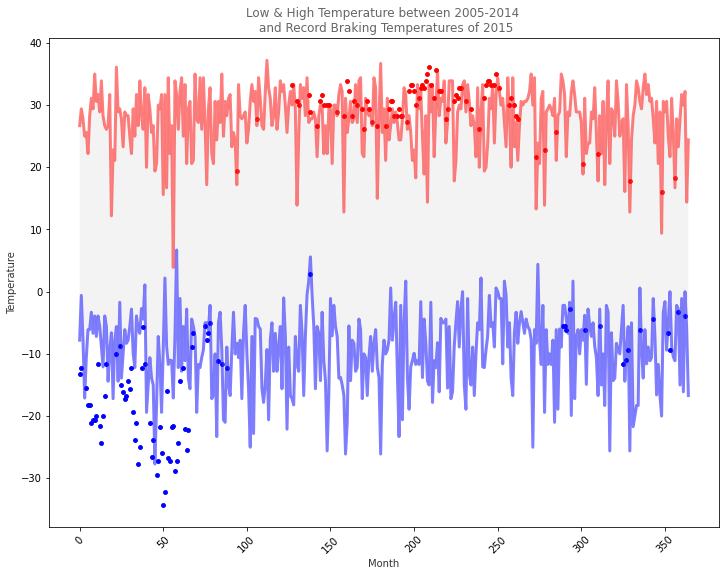

In [52]:
# Dimensões do plotagem
plt.figure(figsize=(12,9))

# Título
plt.title('Low & High Temperature between 2005-2014 \n and Record Braking Temperatures of 2015', alpha =0.6)
ax = plt.gca()  # Obtenha o objeto axes atual

plt.scatter(record_high.index,record_high['Data_Value'], color = 'r', s = 15)
plt.scatter(record_low.index,record_low['Data_Value'], color = 'b', s = 15)

plt.plot(min_tempDec.index, min_tempDec.Data_Value, '-', color = 'b', alpha = 0.5, linewidth=3)
plt.plot(max_tempDec.index, max_tempDec.Data_Value, '-', color = 'r', alpha = 0.5, linewidth=3);


# rotate the tick labels for the x axis
for item in ax.xaxis.get_ticklabels():
    item.set_rotation(45)

ax.set_xlabel('Month', alpha = 0.8)
ax.set_ylabel('Temperature' , alpha = 0.8)

# Preenchendo de cinza entre os gráficos
plt.gca().fill_between(range(len(min_tempDec)), 
                       min_tempDec['Data_Value'], max_tempDec['Data_Value'], 
                       facecolor='lightgray', 
                       alpha=0.25);